In [1]:
import torch
from torchvision import transforms

import torchvision.datasets as datasets
# Using CIFAR-10 dataset
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

from torchvision import models

import numpy as np
import matplotlib.pyplot as plt

from einops import rearrange

from tqdm.notebook import tqdm, trange

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
# Load the CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
resnet_pretrained = models.resnet18(pretrained=True)

# replace the final classification layer with identity to get 512‑dim embeddings
resnet_pretrained.fc = torch.nn.Identity()
# move to device and set to eval mode
resnet_pretrained = resnet_pretrained.to('cuda')
resnet_pretrained.eval()
print("loaded")

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded


In [3]:
embeddings = []

for images, labels in tqdm(test_loader):
    # Forward pass through the model
    with torch.no_grad():
        images = torch.nn.functional.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False).cuda()
        
        features = resnet_pretrained(images)
        embeddings.append(features)

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
embeddings = torch.cat(embeddings, dim=0)
normed_embeddings = torch.nn.functional.normalize(embeddings, dim=1)

kernel_matrix = normed_embeddings @ normed_embeddings.T
print(kernel_matrix.shape)

torch.Size([10000, 10000])


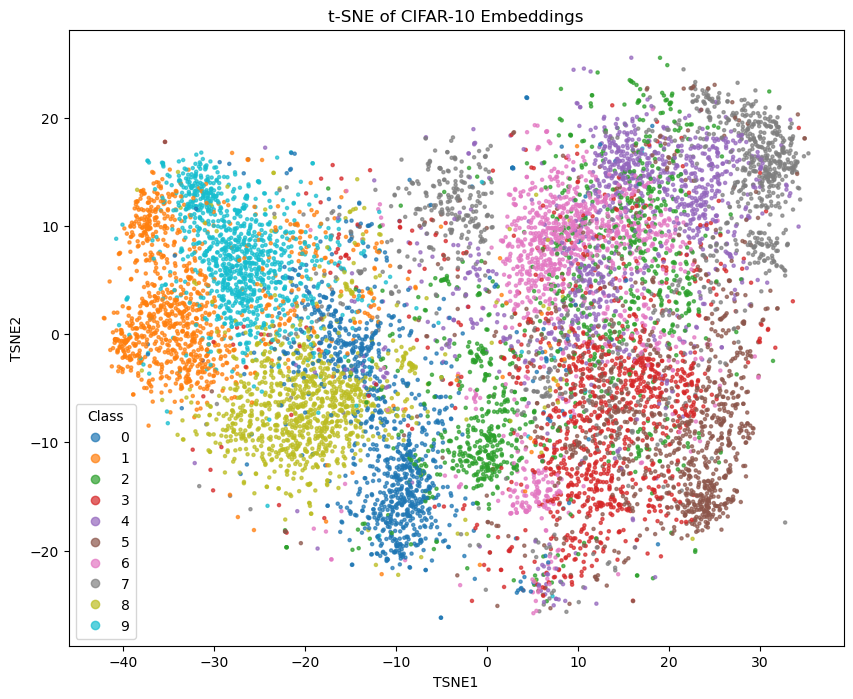

In [38]:
from sklearn.manifold import TSNE

# move embeddings to CPU numpy
emb_np = embeddings.cpu().numpy()

# compute 2D tsne
tsne = TSNE(n_components=2, perplexity=100, random_state=42)
emb_2d = tsne.fit_transform(emb_np)

# get true labels from test_dataset
labels = np.array(test_dataset.targets)

# plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(emb_2d[:, 0], emb_2d[:, 1],
                 c=labels, cmap='tab10', s=5, alpha=0.7)
plt.legend(*sc.legend_elements(), title="Class", loc="best")
plt.title("t-SNE of CIFAR-10 Embeddings")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

In [6]:
# low‑rank approximation of the kernel matrix K ≈ B B^T
r = 256
#remove diagonal elements in kernel matrix: 
#kernel_matrix = kernel_matrix - torch.diag(torch.diag(kernel_matrix))
U, S, _ = torch.linalg.svd(kernel_matrix)
B = (U[:, :r] * torch.sqrt(S[:r])).cpu().numpy()
#approx error
errors = kernel_matrix.cpu().numpy() - B @ B.T
print("approx error", np.linalg.norm(errors, ord='fro'))

approx error 9.429066


  0%|          | 0/10000 [00:00<?, ?it/s]

Fraction in class-1: 0.462


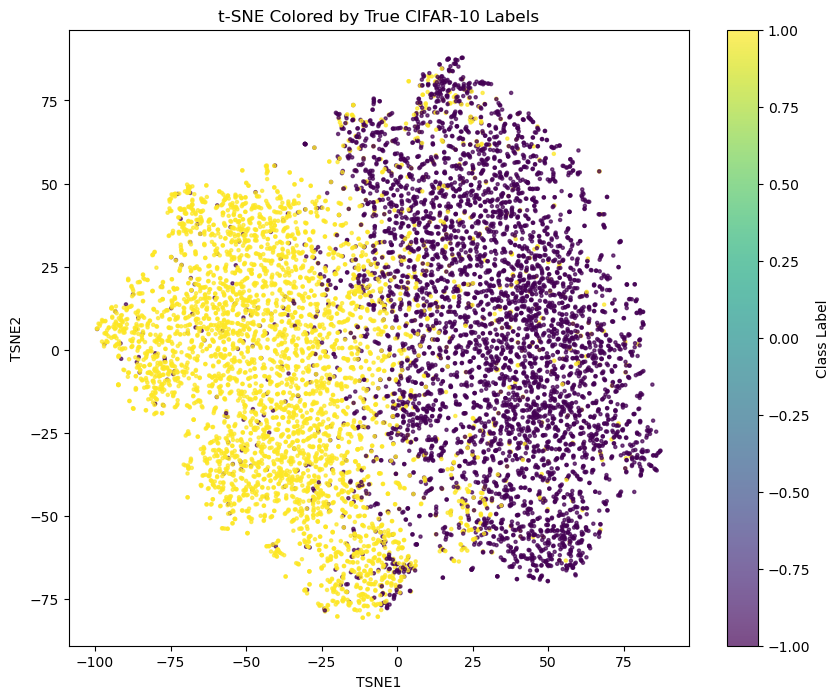

In [7]:
def centre_kernel(B):
    """
    Given low-rank factors  K ≈ B B^T,
    return factors of the centred kernel  K_c = H K H  (row/col sums = 0).
    """
    n, r = B.shape
    B_c  = B - B.mean(axis=0, keepdims=True)   # subtract column means
    return B_c

def lowrank_prefix_sampler(B, T=1.0, seed=None):
    """
    Sequential pseudo-likelihood sampler for an Ising / Potts task prior.
    B  : (n,r) matrix s.t. K ≈ B B^T
    T  : temperature
    returns binary labels in {-1,+1}
    Overall cost  O(n r).
    """
    if seed is not None:
        np.random.seed(seed)
    n, r = B.shape
    beta = 1.0 / T
    s      = np.empty(n, dtype=np.int8)   # labels
    u      = np.zeros(r)                  # running sum   u = B^T s_prefix
    for i in trange(n):
        h_i  = beta * np.dot(B[i], u)         # field from already-sampled spins
        p_i  = 1.0 / (1.0 + np.exp(-2*h_i))   # σ(2h_i)
        s_i  = 1 if np.random.rand() < p_i else -1
        s[i] = s_i
        u   += B[i] * s_i                     # update prefix summary
    return s

labels_final = lowrank_prefix_sampler(centre_kernel(B), T=10)

print("Fraction in class-1:", (labels_final == 1).mean())

plt.figure(figsize=(10, 8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1],
            c=labels_final, s=5, alpha=0.7)
plt.colorbar(label='Class Label')
plt.title("t-SNE Colored by True CIFAR‑10 Labels")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

Fraction in class 0: 0.5159
Fraction in class 1: 0.0011
Fraction in class 2: 0.0005
Fraction in class 3: 0.0469
Fraction in class 4: 0.4326
Fraction in class 5: 0.0004
Fraction in class 6: 0.0004
Fraction in class 7: 0.0005
Fraction in class 8: 0.0014
Fraction in class 9: 0.0003


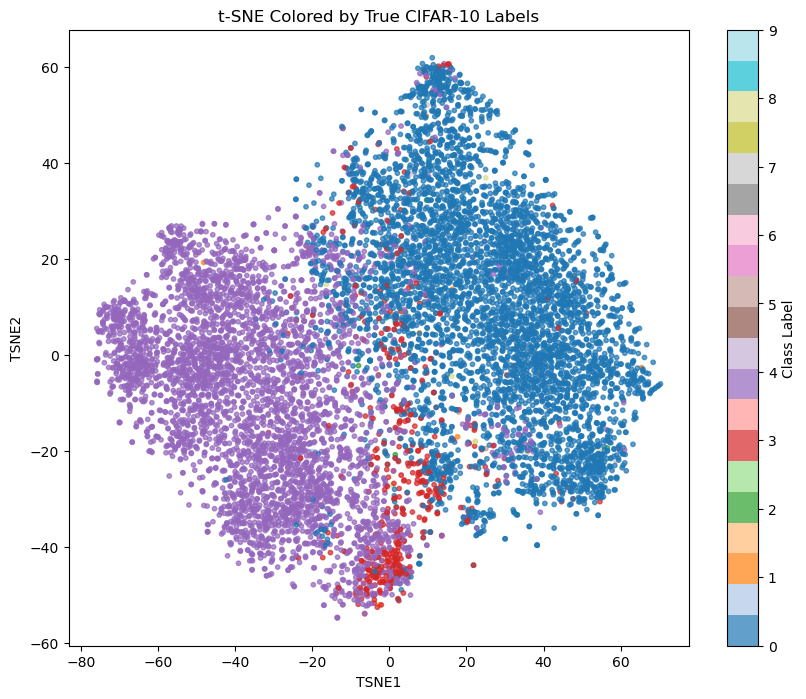

In [37]:
def centre_kernel(B):
    """
    Given low-rank factors  K ≈ B B^T,
    return factors of the centred kernel  K_c = H K H  (row/col sums = 0).
    """
    n, r = B.shape
    B_c  = B - B.mean(axis=0, keepdims=True)   # subtract column means
    return B_c

def lowrank_prefix_sampler_multiclass(B, T=1.0, q=5, seed=None):
    """
    Low-rank prefix sampler for the Potts / multi-class task-prior
        P(y) ∝ exp( β * Tr(Yᵀ K Y) ),   with  K ≈ B Bᵀ ,  β = 1/T.

    Parameters
    ----------
    B   : (n, r) ndarray       low-rank factor (e.g. Nyström or SVD) so K ≈ B Bᵀ
    T   : float                temperature (larger T ⇒ weaker couplings)
    q   : int                  number of classes (q = 5 by default)
    seed: int or None          random seed

    Returns
    -------
    labels : (n,) ndarray of ints in {0,…,q-1}
    """
    if seed is not None:
        np.random.seed(seed)

    n, r   = B.shape
    beta   = 1.0 / T
    labels = np.empty(n, dtype=np.int16)

    # running class-wise prefix sums   U[:, c] = Σ_{j<i, y_j=c} B[j]
    U = np.zeros((r, q), dtype=B.dtype)

    for i in range(n):
        # field for each class:   h_c = β · B[i]^T · U[:, c]
        h = beta * (B[i] @ U)        # shape (q,)

        # softmax to get conditional probabilities  P(y_i=c | prefix)
        h -= h.max()                 # numerical stabilisation
        p = np.exp(h)
        p /= p.sum()

        # sample the class
        c = np.random.choice(q, p=p)
        labels[i] = c

        # update the prefix accumulator for the chosen class
        U[:, c] += B[i]

    return labels

labels_final = lowrank_prefix_sampler_multiclass(centre_kernel(B), T=.1, q =10)

num_classes = labels_final.max() + 1
for c in range(num_classes):
    print(f"Fraction in class {c}:", (labels_final == c).mean())

plt.figure(figsize=(10, 8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1],
            c=labels_final, cmap = "tab20", s=10, alpha=0.7)
plt.colorbar(label='Class Label')
plt.title("t-SNE Colored by True CIFAR‑10 Labels")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

In [ ]:
import math

n = 100       # number of runs
cols = 3    # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), tight_layout=True)
axes = axes.flatten()
labels_list = []

for i in trange(n):
    # sample and plot
    labels_run = lowrank_prefix_sampler_multiclass(centre_kernel(normed_embeddings.cpu().numpy()), T=30, q=2, seed=i)
    labels_list.append(labels_run)
    ax = axes[i]
    #ax.scatter(emb_2d[:, 0], emb_2d[:, 1],
    #           c=labels_run, cmap="tab20", s=5, alpha=1)
    ax.set_title(f"run {i+1}")
    ax.set_xticks([])
    ax.set_yticks([])

# hide any extra axes
for ax in axes[n:]:
    ax.axis("off")

In [44]:
labels_list = np.array(labels_list)
labels_list.shape

np.save('labels_list_new_algo_1.npy', labels_list)